# Malaria Cell Infection
This notebook is used in the National Institute of Health (NIH) Malaria Dataset

URL to the used dataset on Kaggle: https://www.kaggle.com/iarunava/cell-images-for-detecting-malaria

# Getting the datasets
This will extract the data from `./drive/My Drive/malaria-cell-images.zip`. Before running this cell, save the dataset to your drive's using the `malaria-cell-images-to-drive` notebook

In [ ]:
# Skip copy and unzip if the extracted directory exists
![ -d './cell_images' ] || cp './drive/My Drive/malaria-cell-images.zip' './'
![ -d './cell_images' ] || unzip './malaria-cell-images.zip' > /dev/null
!find './cell_images' -type f -name '*.db' -delete

# Some information about the images

In [ ]:
!echo "NUMBER OF POSITIVE IMAGES: $(find ./cell_images/Parasitized -type f | wc -l)"
!echo "NUMBER OF NEGATIVE IMAGES: $(find ./cell_images/Uninfected -type f | wc -l)"
!echo "                    TOTAL: $(find ./cell_images -type f | wc -l)"

NUMBER OF POSITIVE IMAGES: 13779
NUMBER OF NEGATIVE IMAGES: 13779
                    TOTAL: 27558


# Importing the modules

In [ ]:
!pip install pytorch-ignite

     |████████████████████████████████| 184kB 12.2MB/s 


In [ ]:
import math
import os
import shutil

import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from tabulate import tabulate

from ignite.engine import Events, create_supervised_trainer, create_supervised_evaluator
from ignite.metrics import Accuracy, Loss, RunningAverage, ConfusionMatrix
from ignite.handlers import ModelCheckpoint, EarlyStopping

import torch
from torch import optim, nn
import torch.nn.functional as F
from torch.utils.data.sampler import RandomSampler, SubsetRandomSampler
from torchsummary import summary
from torchvision import datasets, models, transforms

# Splitting the dataset
Since we'll not be doing model finetuning, the dataset will be split into *training*, with 80% of the dataset, and *test*, with the remaining 20%.

In [ ]:
def split_images(imgs_root_path, splits_root_path):
    if os.path.exists(splits_root_path):
        shutil.rmtree(splits_root_path)
    os.makedirs(splits_root_path)

    fnames_map = dict()
    img_classes = os.listdir(imgs_root_path)
    datasets = ['train', 'test']
    for img_class in img_classes:
        img_class_root_path = os.path.join(imgs_root_path, img_class)
        fnames = os.listdir(img_class_root_path)

        (train_fnames, test_fnames) = train_test_split(
            fnames, train_size=0.8, shuffle=True)

        fnames_map[('train', img_class)] = train_fnames
        fnames_map[('test',  img_class)] = test_fnames
        for ((dset, img_class), fnames) in fnames_map.items():
            for fname in fnames:
                src_img_path = os.path.join(imgs_root_path, img_class, fname)
                dst_img_path = os.path.join(splits_root_path, dset, img_class, fname)

                if not os.path.exists(os.path.dirname(dst_img_path)):
                    os.makedirs(os.path.dirname(dst_img_path))

                shutil.copy(src_img_path, dst_img_path)

    table_headers = datasets
    table_data = list()
    for c in img_classes:
        row = [c]
        for d in datasets:
            abs_freq = len(fnames_map[(d, c)])
            row.append(abs_freq)
        table_data.append(row)
    print('SPLITS ABS. FREQUENCY')
    print(tabulate(tabular_data=table_data, headers=table_headers, tablefmt='github'))

In [ ]:
%%time
split_images('./cell_images', 'datasets')

SPLITS ABS. FREQUENCY
|             |   train |   test |
|-------------|---------|--------|
| Parasitized |   11023 |   2756 |
| Uninfected  |   11023 |   2756 |
CPU times: user 1.5 s, sys: 2.68 s, total: 4.18 s
Wall time: 4.93 s


# Helper functions

## Defining the data loaders function

In [ ]:
def create_transforms(img_res):
    train_transforms = transforms.Compose(
        [
            transforms.Resize(IMG_RES),
            transforms.RandomHorizontalFlip(),
            transforms.RandomVerticalFlip(),
            transforms.RandomRotation(45),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]
    )

    eval_transforms = transforms.Compose(
        [
            transforms.Resize(IMG_RES),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
        ]
    )

    return (train_transforms, eval_transforms)


def create_data_loaders(img_res):
    (train_transforms, eval_transforms) = create_transforms(img_res)
    train_dataset = datasets.ImageFolder('./datasets/train', transform=train_transforms)
    test_dataset =  datasets.ImageFolder('./datasets/test',  transform=eval_transforms)

    train_sampler = RandomSampler(train_dataset)
    test_sampler =  RandomSampler(test_dataset)

    train_loader = torch.utils.data.DataLoader(
        train_dataset,
        batch_size=BATCH_SIZE,
        sampler=train_sampler,
        num_workers=NUM_WORKERS
    )

    test_loader = torch.utils.data.DataLoader(
        test_dataset,
        batch_size=BATCH_SIZE,
        sampler=test_sampler,
        num_workers=NUM_WORKERS
    )

    return (train_loader, test_loader)

## Defining the training, validation and test procedure

In [ ]:
def create_training_procedure(model, optimizer, criterion, device, train_loader,
                              test_loader):
    trainer = create_supervised_trainer(model, optimizer, criterion, device=device)
    metrics = {
        'Accuracy': Accuracy(),
        'Loss': Loss(criterion)
    }

    evaluator = create_supervised_evaluator(model, metrics=metrics, device=device)
    train_history = {'accuracy': list(), 'loss': list()}
    test_history = {'accuracy': list(), 'loss': list()}
    last_epoch = list()
    RunningAverage(output_transform=lambda x: x).attach(trainer, 'loss')

    # The commented lines below add early stopping but for the purposes of this notebook
    # we won't be using it
    # def score_function(engine):
    #     val_loss = engine.state.metrics['Loss']
    #     return -val_loss

    # handler = EarlyStopping(patience=10, score_function=score_function, trainer=trainer)
    # evaluator.add_event_handler(Events.COMPLETED, handler)

    def get_acc_and_loss(data_loader):
        evaluator.run(data_loader)
        metrics = evaluator.state.metrics
        accuracy = metrics['Accuracy'] * 100
        loss = metrics['Loss']

        return (accuracy, loss)


    @trainer.on(Events.EPOCH_COMPLETED)
    def log_epoch_results(trainer):
        (train_acc, train_loss) = get_acc_and_loss(train_loader)
        train_history['accuracy'].append(train_acc)
        train_history['loss'].append(train_loss)

        (test_acc, test_loss) = get_acc_and_loss(test_loader)
        test_history['accuracy'].append(test_acc)
        test_history['loss'].append(test_loss)

        print(
            f'Epoch: {trainer.state.epoch:>2},',
            f'Train Avg. Acc.: {train_acc:.2f},',
            f'Train Avg. Loss: {train_loss:.2f} -',
            f'Test Avg. Acc.: {test_acc:.2f},',
            f'Test Avg. Loss: {test_loss:.2f}'
        )


    checkpointer = ModelCheckpoint(
            './saved_models', 'baseline-cnn', n_saved=2, create_dir=True,
            save_as_state_dict=True, require_empty=False)

    _ = trainer.add_event_handler(
            Events.EPOCH_COMPLETED, checkpointer, {'baseline-cnn': model})

    return (trainer, train_history, test_history)

## Defining the experiment plots

In [ ]:
def display_results(train_history, test_history, title):
    plt.plot(train_history['accuracy'],label="Training Accuracy")
    plt.plot(test_history['accuracy'],label="Test Accuracy")
    plt.xlabel('No. of Epochs')
    plt.ylabel('Accuracy')
    plt.legend(frameon=False)
    plt.title(title)
    plt.show()

    plt.plot(train_history['loss'],label="Training Loss")
    plt.plot(test_history['loss'],label="Test Loss")
    plt.xlabel('No. of Epochs')
    plt.ylabel('Loss')
    plt.legend(frameon=False)
    plt.title(title)
    plt.show()

## Defining the calculation of convolution shape propagation
Using these helpers to calculate how the image shrinks through the convolutional layers

In [ ]:
def filter_shape(width, kernel_size, padding=1, stride=1):
    div = width + (2 * padding) - kernel_size
    return math.floor(div / stride) + 1


def conv(width, kernel_size, padding=1, stride=1):
    return filter_shape(width, kernel_size, padding=padding, stride=stride)


def pool(width, pool_size, stride=2):
    return filter_shape(width, kernel_size=pool_size, padding=0, stride=stride)

## Defining a rapid shape mismatch test
We'll run forward propagation on a single batch to check for input shape mismatch between the convolutional and fully-connected layers

In [ ]:
def test_forward_prop(model, train_loader, device):
    """
    A simple shape mismatch test for the forward propagation
    """
    (data, target) = next(iter(train_loader))
    (data, target) = (data.to(device), target.to(device))

    logits = model(data)
    (batch_size, num_classes) = logits.shape
    print(f'NO SHAPE MISMATCH ERRORS IT SEEMS...')
    print(f'BATCH SIZE: {batch_size}, NUM. CLASSES: {num_classes}')

# Experiment - Baseline CNN
URL: https://www.kaggle.com/pradheeprio/malaria-cell-image-detection-using-cnn-acc-95

## Configuring the parameters

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE USED: {DEVICE}')

RANDOM_SEED = 42
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
IMG_RES = (68, 68)
NUM_WORKERS = 2

NUM_CLASSES = 2
_ = torch.manual_seed(RANDOM_SEED)

DEVICE USED: cuda


## Creating the train and test data loaders

In [ ]:
(train_loader, test_loader) = create_data_loaders(IMG_RES)

## Implementing the model

In [ ]:
w = IMG_RES[0]
print(f'INPUT WIDTH: {w}', end='\n\n')

w = conv(width=w, kernel_size=3, padding=0, stride=1)
print(f'C1: {w}, in_ch: 3, out_ch: 16')

w = pool(width=w, pool_size=2)
print(f'P1: {w}', end='\n\n')

w = conv(width=w, kernel_size=3, padding=0, stride=1)
print(f'C2: {w}, in_ch: 16, out_ch: 64')

w = pool(width=w, pool_size=2)
print(f'P2: {w}', end='\n\n')
print(f'FLAT SHAPE: {w * w * 64}')

INPUT WIDTH: 68

C1: 66, in_ch: 3, out_ch: 16
P1: 33

C2: 31, in_ch: 16, out_ch: 64
P2: 15

FLAT SHAPE: 14400


In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=16, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=0),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2),
            nn.Dropout2d(p=0.3)
        )

        self.dense_block = nn.Sequential(
            nn.Linear(in_features=15 * 15 * 64, out_features=64),
            nn.ReLU(),
            nn.Dropout(p=0.5),
            nn.Linear(in_features=64, out_features=num_classes)
        )

    def forward(self, X):
        out = X

        out = self.conv_block1(out)
        out = self.conv_block2(out)
        out = torch.flatten(out, 1)
        out = self.dense_block(out)

        return out

### Testing the propagation with a single batch

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE USED: {DEVICE}')

model = BaselineCNN(num_classes=2).to(DEVICE)
test_forward_prop(model, train_loader, DEVICE)

DEVICE USED: cuda
NO SHAPE MISMATCH ERRORS IT SEEMS...
BATCH SIZE: 64, NUM. CLASSES: 2


## Printing the model's summary

In [ ]:
model = BaselineCNN(num_classes=2).to(DEVICE)
summary(model, input_size=(3, 68, 68))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 66, 66]             448
              ReLU-2           [-1, 16, 66, 66]               0
         MaxPool2d-3           [-1, 16, 33, 33]               0
         Dropout2d-4           [-1, 16, 33, 33]               0
            Conv2d-5           [-1, 64, 31, 31]           9,280
              ReLU-6           [-1, 64, 31, 31]               0
         MaxPool2d-7           [-1, 64, 15, 15]               0
         Dropout2d-8           [-1, 64, 15, 15]               0
            Linear-9                   [-1, 64]         921,664
             ReLU-10                   [-1, 64]               0
          Dropout-11                   [-1, 64]               0
           Linear-12                    [-1, 2]             130
Total params: 931,522
Trainable params: 931,522
Non-trainable params: 0
-------------------------------

## Running the experiment
The model will be trained with three values of learning rate 0.001, 0.055, and 0.01.

# MODEL: Baseline CNN, LR: 0.001
Epoch:  1, Train Avg. Acc.: 91.79, Train Avg. Loss: 0.24 - Test Avg. Acc.: 92.63, Test Avg. Loss: 0.23
Epoch:  2, Train Avg. Acc.: 93.96, Train Avg. Loss: 0.18 - Test Avg. Acc.: 94.56, Test Avg. Loss: 0.17
Epoch:  3, Train Avg. Acc.: 95.03, Train Avg. Loss: 0.16 - Test Avg. Acc.: 95.46, Test Avg. Loss: 0.15
Epoch:  4, Train Avg. Acc.: 95.30, Train Avg. Loss: 0.15 - Test Avg. Acc.: 95.41, Test Avg. Loss: 0.14
Epoch:  5, Train Avg. Acc.: 95.42, Train Avg. Loss: 0.14 - Test Avg. Acc.: 95.59, Test Avg. Loss: 0.13
Epoch:  6, Train Avg. Acc.: 95.46, Train Avg. Loss: 0.14 - Test Avg. Acc.: 95.68, Test Avg. Loss: 0.13
Epoch:  7, Train Avg. Acc.: 95.34, Train Avg. Loss: 0.14 - Test Avg. Acc.: 95.32, Test Avg. Loss: 0.14
Epoch:  8, Train Avg. Acc.: 95.54, Train Avg. Loss: 0.13 - Test Avg. Acc.: 95.74, Test Avg. Loss: 0.13
Epoch:  9, Train Avg. Acc.: 95.46, Train Avg. Loss: 0.14 - Test Avg. Acc.: 95.41, Test Avg. Loss: 0.13
Epoch: 10, Train Avg. Acc.: 95.32, Train

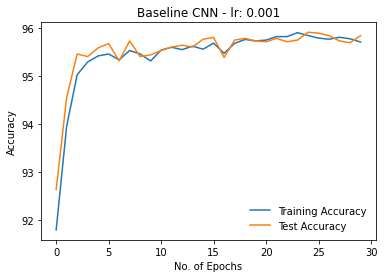

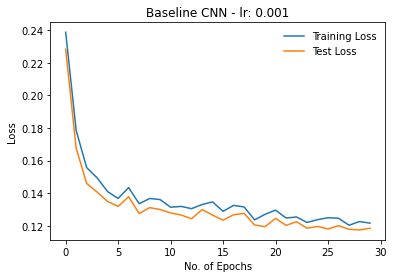

CPU times: user 2min 16s, sys: 54.6 s, total: 3min 10s
Wall time: 23min 48s


In [ ]:
%%time
model_name = 'Baseline CNN'

model = BaselineCNN(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

(trainer, train_history, test_history) = create_training_procedure(
        model, optimizer, criterion, DEVICE, train_loader, test_loader)

print(f'# MODEL: {model_name}, LR: {lr}')
state = trainer.run(train_loader, max_epochs=NUM_EPOCHS)
display_results(train_history, test_history,
                f'{model_name} - lr: {lr}')

# Experiment - LeNet-5
URL: https://towardsdatascience.com/implementing-yann-lecuns-lenet-5-in-pytorch-5e05a0911320

## Configuring the Parameters

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE USED: {DEVICE}')

RANDOM_SEED = 42
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
IMG_RES = (32, 32)
NUM_WORKERS = 2

NUM_CLASSES = 2
_ = torch.manual_seed(RANDOM_SEED)

DEVICE USED: cuda


## Creating the train and test data loaders

In [ ]:
(train_loader, test_loader) = create_data_loaders(IMG_RES)

## Implementing the model

In [ ]:
w = IMG_RES[0]
print(f'INPUT WIDTH: {w}', end='\n\n')

w = conv(width=w, kernel_size=5, padding=0, stride=1)
print(f'C1: {w}, in_ch: 3, out_ch: 6')
w = pool(width=w, pool_size=2)
print(f'P1: {w}', end='\n\n')

w = conv(width=w, kernel_size=5, padding=0, stride=1)
print(f'C2: {w}, in_ch: 6, out_ch: 16')
w = pool(width=w, pool_size=2)
print(f'P2: {w}', end='\n\n')

w = conv(width=w, kernel_size=5, padding=0, stride=1)
print(f'C3: {w}, in_ch: 16, out_ch: 120')

print(f'FLATTENED SHAPE: {w * w * 120}')

INPUT WIDTH: 32

C1: 28, in_ch: 3, out_ch: 6
P1: 14

C2: 10, in_ch: 6, out_ch: 16
P2: 5

C3: 1, in_ch: 16, out_ch: 120
FLATTENED SHAPE: 120


In [ ]:
class LeNet5(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        self.conv_block1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )

        self.conv_block2 = nn.Sequential(
            nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride=1, padding=0),
            nn.Tanh(),
            nn.AvgPool2d(kernel_size=2)
        )

        self.conv_block3 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=120, kernel_size=5, stride=1, padding=0),
            nn.Tanh()
        )

        self.dense_block = nn.Sequential(
            nn.Linear(in_features=1 * 1 * 120, out_features=84),
            nn.Tanh(),
            nn.Linear(in_features=84, out_features=num_classes)
        )

    def forward(self, X):
        out = X

        out = self.conv_block1(out)
        out = self.conv_block2(out)
        out = self.conv_block3(out)
        out = torch.flatten(out, 1)
        out = self.dense_block(out)

        return out

### Testing the propagation with a single batch

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE USED: {DEVICE}')

model = LeNet5(num_classes=2).to(DEVICE)
test_forward_prop(model, train_loader, DEVICE)

DEVICE USED: cuda
NO SHAPE MISMATCH ERRORS IT SEEMS...
BATCH SIZE: 64, NUM. CLASSES: 2


## Printing the model's summary

In [ ]:
model = LeNet5(num_classes=2).to(DEVICE)
summary(model, input_size=(3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 6, 28, 28]             456
              Tanh-2            [-1, 6, 28, 28]               0
         AvgPool2d-3            [-1, 6, 14, 14]               0
            Conv2d-4           [-1, 16, 10, 10]           2,416
              Tanh-5           [-1, 16, 10, 10]               0
         AvgPool2d-6             [-1, 16, 5, 5]               0
            Conv2d-7            [-1, 120, 1, 1]          48,120
              Tanh-8            [-1, 120, 1, 1]               0
            Linear-9                   [-1, 84]          10,164
             Tanh-10                   [-1, 84]               0
           Linear-11                    [-1, 2]             170
Total params: 61,326
Trainable params: 61,326
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/ba

## Running the experiment
The model will be trained with three values of learning rate 0.001, 0.055, and 0.01.

# MODEL: LeNet-5, LR: 0.001
Epoch:  1, Train Avg. Acc.: 67.85, Train Avg. Loss: 0.60 - Test Avg. Acc.: 67.13, Test Avg. Loss: 0.61
Epoch:  2, Train Avg. Acc.: 70.43, Train Avg. Loss: 0.58 - Test Avg. Acc.: 69.58, Test Avg. Loss: 0.58
Epoch:  3, Train Avg. Acc.: 70.55, Train Avg. Loss: 0.56 - Test Avg. Acc.: 70.28, Test Avg. Loss: 0.57
Epoch:  4, Train Avg. Acc.: 73.08, Train Avg. Loss: 0.54 - Test Avg. Acc.: 72.70, Test Avg. Loss: 0.55
Epoch:  5, Train Avg. Acc.: 79.79, Train Avg. Loss: 0.44 - Test Avg. Acc.: 78.86, Test Avg. Loss: 0.45
Epoch:  6, Train Avg. Acc.: 84.31, Train Avg. Loss: 0.36 - Test Avg. Acc.: 84.02, Test Avg. Loss: 0.36
Epoch:  7, Train Avg. Acc.: 84.04, Train Avg. Loss: 0.37 - Test Avg. Acc.: 82.51, Test Avg. Loss: 0.38
Epoch:  8, Train Avg. Acc.: 86.48, Train Avg. Loss: 0.31 - Test Avg. Acc.: 85.96, Test Avg. Loss: 0.32
Epoch:  9, Train Avg. Acc.: 88.03, Train Avg. Loss: 0.29 - Test Avg. Acc.: 87.34, Test Avg. Loss: 0.30
Epoch: 10, Train Avg. Acc.: 88.03, Train Avg.

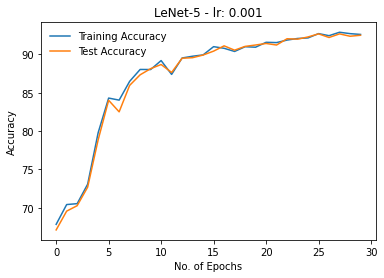

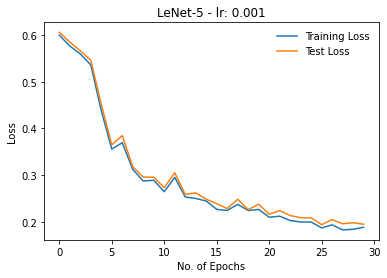

CPU times: user 1min 33s, sys: 15.9 s, total: 1min 49s
Wall time: 24min 6s


In [ ]:
%%time
model_name = 'LeNet-5'

model = LeNet5(num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

(trainer, train_history, test_history) = create_training_procedure(
        model, optimizer, criterion, DEVICE, train_loader, test_loader)

print(f'# MODEL: {model_name}, LR: {lr}')
state = trainer.run(train_loader, max_epochs=NUM_EPOCHS)
display_results(train_history, test_history,
                f'{model_name} - lr: {lr}')

# Experiment - ResNet18

## Configuring the parameters

In [ ]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'DEVICE USED: {DEVICE}')

RANDOM_SEED = 42
BATCH_SIZE = 64
NUM_EPOCHS = 30
LEARNING_RATE = 0.001
IMG_RES = (244, 244)
NUM_WORKERS = 2

NUM_CLASSES = 2
_ = torch.manual_seed(RANDOM_SEED)

DEVICE USED: cuda


## Creating the train and test data loaders

In [ ]:
(train_loader, test_loader) = create_data_loaders(IMG_RES)

## Printing the model's summary

In [ ]:
model = models.resnet18(pretrained=False, num_classes=2).to(DEVICE)
summary(model, input_size=(3, 224, 224))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

## Running the experiment
The model will be trained with three values of learning rate 0.001, 0.055, and 0.01.

# MODEL: ResNet18, LR: 0.001
Epoch:  1, Train Avg. Acc.: 95.53, Train Avg. Loss: 0.14 - Test Avg. Acc.: 95.74, Test Avg. Loss: 0.14
Epoch:  2, Train Avg. Acc.: 94.22, Train Avg. Loss: 0.17 - Test Avg. Acc.: 94.90, Test Avg. Loss: 0.15
Epoch:  3, Train Avg. Acc.: 95.80, Train Avg. Loss: 0.13 - Test Avg. Acc.: 96.28, Test Avg. Loss: 0.13
Epoch:  4, Train Avg. Acc.: 95.70, Train Avg. Loss: 0.14 - Test Avg. Acc.: 95.90, Test Avg. Loss: 0.14
Epoch:  5, Train Avg. Acc.: 95.64, Train Avg. Loss: 0.13 - Test Avg. Acc.: 96.39, Test Avg. Loss: 0.11
Epoch:  6, Train Avg. Acc.: 94.96, Train Avg. Loss: 0.14 - Test Avg. Acc.: 95.48, Test Avg. Loss: 0.13
Epoch:  7, Train Avg. Acc.: 96.20, Train Avg. Loss: 0.12 - Test Avg. Acc.: 96.59, Test Avg. Loss: 0.11
Epoch:  8, Train Avg. Acc.: 95.77, Train Avg. Loss: 0.12 - Test Avg. Acc.: 95.86, Test Avg. Loss: 0.12
Epoch:  9, Train Avg. Acc.: 96.11, Train Avg. Loss: 0.12 - Test Avg. Acc.: 96.39, Test Avg. Loss: 0.12
Epoch: 10, Train Avg. Acc.: 96.16, Train Avg

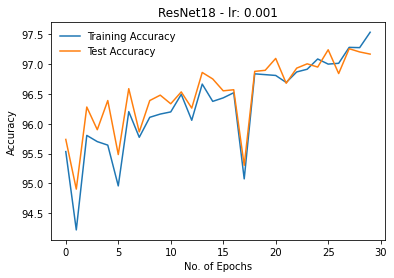

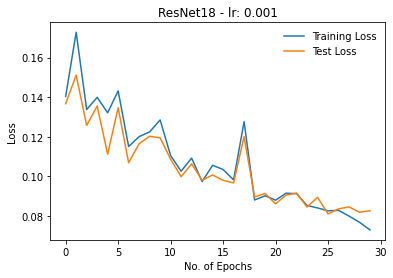

CPU times: user 35min 57s, sys: 21min 56s, total: 57min 53s
Wall time: 1h 29min 49s


In [ ]:
%%time
model_name = 'ResNet18'
model = models.resnet18(pretrained=False, num_classes=NUM_CLASSES).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)
criterion = nn.CrossEntropyLoss()

(trainer, train_history, test_history) = create_training_procedure(
        model, optimizer, criterion, DEVICE, train_loader, test_loader)

print(f'# MODEL: {model_name}, LR: {lr}')
state = trainer.run(train_loader, max_epochs=NUM_EPOCHS)
display_results(train_history, test_history,
                f'{model_name} - lr: {lr}')